# Visualizing BayesOpt

In [1]:
import jax.numpy as jnp
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from jax.scipy.stats import norm
from tqdm import tqdm

from hyperoptax.acquisition import EI, UCB
from hyperoptax.bayesian import BayesianOptimizer
from hyperoptax.kernels import Matern
from hyperoptax.spaces import LinearSpace

In [2]:
def f(x, y):
    return jnp.cos(2 * jnp.pi * x) + jnp.cos(2 * jnp.pi * y) - 0.3 * x**2 - 0.3 * y**2


In [3]:
x = jnp.linspace(-2, 2, 1001)
y = jnp.linspace(-2, 2, 1001)
X, Y = jnp.meshgrid(x, y)
fxy = f(X, Y)

flat_index = jnp.argmax(fxy)
max_coords = jnp.unravel_index(flat_index, fxy.shape)
y_idx, x_idx = max_coords
x[x_idx], y[y_idx], fxy[y_idx, x_idx]

(Array(5.9604645e-08, dtype=float32),
 Array(5.9604645e-08, dtype=float32),
 Array(2., dtype=float32))

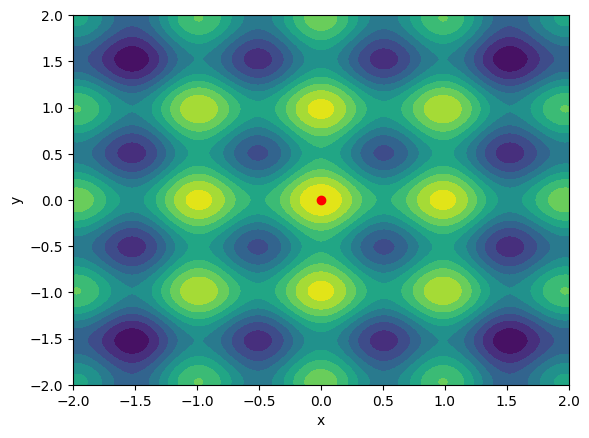

In [4]:
fig, ax = plt.subplots()
ax.contourf(X, Y, fxy, levels=10)
ax.plot(x[x_idx], y[y_idx], "ro")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

In [5]:
# set up stuff
hoptax_bounds = {"x": LinearSpace(-3, 3, 100), "y": LinearSpace(-3, 3, 100)}
acqui = EI(xi=0.01, stochastic_multiplier=30)
acqui = UCB(kappa=3.0, stochastic_multiplier=30)

optim = BayesianOptimizer(
    hoptax_bounds,
    f=f,
    jitter=1e-5,
    acquisition=acqui,
    kernel=Matern(nu=1.5, length_scale=0.5),
)
n_iterations = 200
n_vmap = 10
# run
results = optim.optimize(n_iterations=n_iterations, n_vmap=n_vmap, jit=True)

x_seen, y_seen = optim.results

In [6]:
X = jnp.linspace(-3, 3, 100)
Y = jnp.linspace(-3, 3, 100)

# Create regular grid
xi, yi = jnp.meshgrid(X, Y)
fxy = f(xi, yi)

means = []
stds = []
acquisitions = []
candidates = []

for i in range(n_vmap, n_iterations, n_vmap):
    x, y = x_seen[:i], y_seen[:i]
    mean, std = optim.fit_gp(x, y)
    acquisition = acqui(mean, std)
    candidate = x_seen[i : i + n_vmap]

    means.append(mean)
    stds.append(std)
    acquisitions.append(acquisition)
    candidates.append(candidate)


In [7]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
min_means = jnp.min(jnp.array(means))
max_means = jnp.max(jnp.array(means))
min_stds = jnp.min(jnp.array(stds))
max_stds = jnp.max(jnp.array(stds))
min_acq = jnp.min(jnp.array(acquisitions))
max_acq = jnp.max(jnp.array(acquisitions))

# Set up titles
axs[0, 0].set_title("f(x, y)")
axs[0, 1].set_title("Mean")
axs[1, 0].set_title("Acquisition")
axs[1, 1].set_title("Standard Deviation")

# Turn off grid for all subplots
for i in range(2):
    for j in range(2):
        axs[i, j].grid(False)

writer = animation.PillowWriter(fps=1)
writer.setup(fig, "gp_animation.gif", dpi=300)


def update_plot(frame):
    # Clear all axes except the true function
    for i in range(2):
        for j in range(2):
            if not (i == 0 and j == 0):  # Don't clear the true function plot
                axs[i, j].clear()

    # Plot true function (stays constant)
    axs[0, 0].contourf(xi, yi, fxy, levels=20)
    axs[0, 0].set_title("f(x, y)")

    # Plot mean
    axs[0, 1].contourf(
        xi,
        yi,
        means[frame].reshape(100, 100),
        levels=20,
        vmin=min_means,
        vmax=max_means,
    )
    axs[0, 1].set_title("Mean")

    # Plot acquisition function with sampled points
    axs[1, 0].contourf(
        xi,
        yi,
        acquisitions[frame].reshape(100, 100),
        levels=20,
        vmin=min_acq,
        vmax=max_acq,
    )
    axs[1, 0].plot(candidates[frame][:, 0], candidates[frame][:, 1], "r.", alpha=0.5)

    axs[1, 0].set_title("Acquisition Function")
    axs[1, 0].set_xlim(-3, 3)
    axs[1, 0].set_ylim(-3, 3)

    # Plot standard deviation with sampled points
    axs[1, 1].contourf(
        xi, yi, stds[frame].reshape(100, 100), levels=20, vmin=min_stds, vmax=max_stds
    )
    axs[1, 1].set_title("Standard Deviation")
    axs[1, 1].set_xlim(-3, 3)
    axs[1, 1].set_ylim(-3, 3)

    # Turn off grid for all subplots
    for i in range(2):
        for j in range(2):
            axs[i, j].grid(False)

    # Add overall title
    fig.suptitle(f"Bayesian Optimization - Iteration {frame * n_vmap + n_vmap}")
    plt.tight_layout()


# Create animation frames
n_frames = len(means)
print(f"Creating {n_frames} frames...")

for frame in tqdm(range(n_frames)):
    update_plot(frame)
    writer.grab_frame()

# Finish and clean up
writer.finish()
plt.close(fig)
print("Animation saved as 'gp_animation.gif'")

Creating 19 frames...


100%|██████████| 19/19 [00:05<00:00,  3.70it/s]


Animation saved as 'gp_animation.gif'
